# Imports

In [103]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print(plt.style.available)


plt.style.use('mystyle')

#print(plt.rcParams)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['figure.facecolor'] = 'w'
#plt.rcParams['grid.linestyle'] = 'dashed'
#plt.rcParams['font.size'] = 20
#plt.rcParams['axes.edgecolor'] = '#afafaf'
#plt.rcParams['grid.color'] = '#afafaf'
#plt.rcParams['axes.facecolor'] = '#fafafa'
#plt.rcParams['axes.facecolor'] = 'w'
#plt.rcParams['figure.facecolor'] = '#fafafa'
#plt.rcParams['figure.facecolor'] = 'w'

['seaborn-colorblind', 'seaborn-darkgrid', 'fivethirtyeight', 'seaborn-dark', 'seaborn-paper', 'dark_background', 'classic', 'seaborn-talk', 'mystyle', 'seaborn-dark-palette', 'seaborn-deep', 'seaborn-white', 'seaborn-notebook', 'seaborn-bright', 'ggplot', 'seaborn-poster', 'bmh', 'grayscale', 'seaborn-whitegrid', 'seaborn-pastel', 'seaborn-ticks', 'seaborn-muted']


In [104]:
import astropy
import astropy.coordinates as coord
import astropy.units as u

import astropy.constants as c
from astropy.table import Table

# Zwicky catalog of galaxies

In [105]:
uzcat = pd.read_table('data/uzcJ2000.tab/uzcJ2000.tab', 
                   sep='\t', 
                   header=16, 
                   dtype='str',
                   names=['ra', 'dec', 'Zmag', 'cz', 'cze', 'T', 'U', 'Ne',
                           'Zname', 'C', 'Ref', 'Oname', 'M', 'N'],
                   skiprows=[17])

In [106]:
uzcat.head()

,ra,dec,Zmag,cz,cze,T,U,Ne,Zname,C,Ref,Oname,M,N
0,000237.9,+163838,14.9,6350,19,A,1,0,000000+16220,F,,I5378S,,
1,000246.3,+185310,14.8,7864,47,A,0,0,000012+18370,Z,0650,00002+1837,,
2,000257.0,+041231,15.5,8695,40,E,0,0,000030+03560,Z,2700,00005+0356,,
3,000302.9,+185221,15.5,8007,39,E,0,0,000030+18360,Z,0650,00005+1836,,
4,000305.6,-015450,14.3,7298,42,B,0,0,000036-02110,Z,2218,00006-0211,,


In [107]:
uzcat['ra'] = uzcat['ra'].apply(lambda x: '{0}h{1}m{2}s'.format(x[:2],x[2:4],x[4:]))
uzcat['dec'] = uzcat['dec'].apply(lambda x: '{0}d{1}m{2}s'.format(x[:3],x[3:5],x[5:]))

In [108]:
coords_uzc = coord.SkyCoord(uzcat['ra'], uzcat['dec'], frame='fk5', equinox='J2000')

In [109]:
coords_uzc.ra.deg.min()

0.0070833333333333321

In [110]:
uzcat = uzcat.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)
uzcat['cz'] = uzcat['cz'].astype('float')

In [111]:
color_czs = (uzcat['cz']+abs(uzcat['cz'].min())) / (uzcat['cz'].max()+abs(uzcat['cz'].min()))

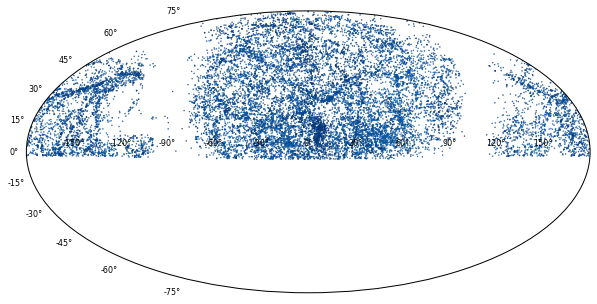

In [112]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(coords_uzc.ra.radian-np.pi, coords_uzc.dec.radian, 
           color=plt.cm.Blues_r(color_czs), alpha=0.7,
           s=4, marker='.', zorder=-1);

In [113]:
uzc_czs = uzcat['cz'].as_matrix()
uzcat['Zmag'] = uzcat['Zmag'].astype('float')
decmin = 15
decmax = 30
ramin = 90
ramax = 295
czmin = 0
czmax = 12500
selection_dec = (coords_uzc.dec.deg>decmin) * (coords_uzc.dec.deg<decmax)
selection_ra = (coords_uzc.ra.deg>ramin) * (coords_uzc.ra.deg<ramax)
selection_czs = (uzc_czs>czmin) * (uzc_czs<czmax)
selection= selection_dec * selection_ra * selection_czs

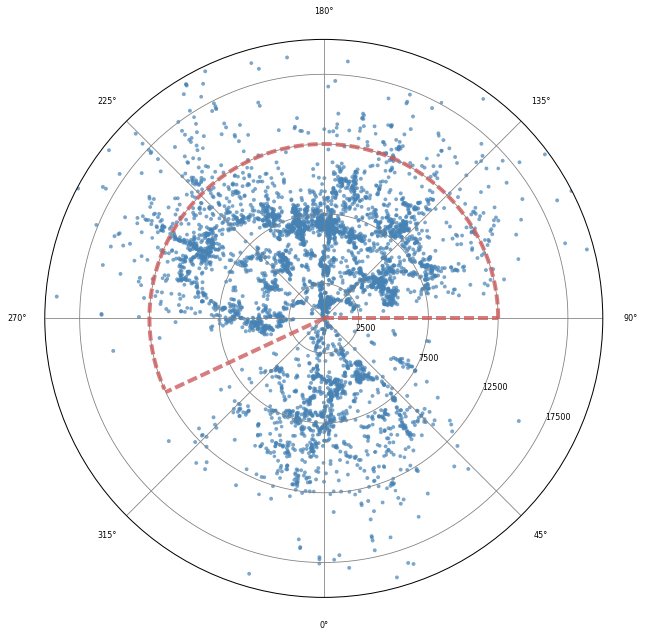

In [123]:
fig = plt.figure( figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
sct = ax.scatter(coords_uzc.ra.radian[selection_dec], uzc_czs[selection_dec], 
                     color='SteelBlue',
                     #color=plt.cm.RdBu((coords_uzc.dec.deg[selection])/100.), 
                     s=uzcat['Zmag'][selection_dec*selection_czs], 
                     edgecolors="none", 
                     alpha=0.7,
                    zorder=0)
ax.set_rlim(0,20000)
ax.set_theta_offset(np.pi/-2)
ax.set_rlabel_position(65)
ax.set_rticks(range(2500,20001,5000));
ax.plot([(ramin*u.deg).to(u.radian).value, (ramin*u.deg).to(u.radian).value], [0,12500], 
        color='IndianRed', alpha=0.8, dashes=(10,4), lw=4)
ax.plot([ramax*np.pi/180., ramax*np.pi/180.], [0,12500],
        color='IndianRed', alpha=0.8, dashes=(10,4), lw=4)
theta = np.arange(ramin, ramax, 1)
ax.plot(theta*np.pi/180., np.ones_like(theta)*12500,
        color='IndianRed', alpha=0.8, dashes=(10,4), lw=4);

In [115]:
mycat = uzcat.copy(deep=True).loc[selection]
mycat['ra_deg'] = coords_uzc.ra.deg[selection]
mycat['dec_deg'] = coords_uzc.dec.deg[selection]

In [116]:
mycat.Zmag = mycat.Zmag.astype('float')
mycat.Zmag.head()


3201    15.4
3221    15.5
3231    15.4
3249    15.4
3254    15.3
Name: Zmag, dtype: float64

In [117]:
zs = (((mycat['cz'].as_matrix()*u.km/u.s) / c.c).decompose())
dist = coord.Distance(z=zs)
print(dist)
mycat['dist'] = dist

[  62.79998101  172.23410971  145.40065934 ...,   64.30473839   61.81198342
   57.46582197] Mpc


In [118]:
coords_xyz = coord.SkyCoord(ra=mycat['ra_deg']*u.deg, dec=mycat['dec_deg']*u.deg, distance=dist*u.Mpc, frame='fk5', equinox='J2000')

In [119]:
mycat['X'] = coords_xyz.cartesian.x.value
mycat['Y'] = coords_xyz.cartesian.y.value
mycat['Z'] = coords_xyz.cartesian.z.value

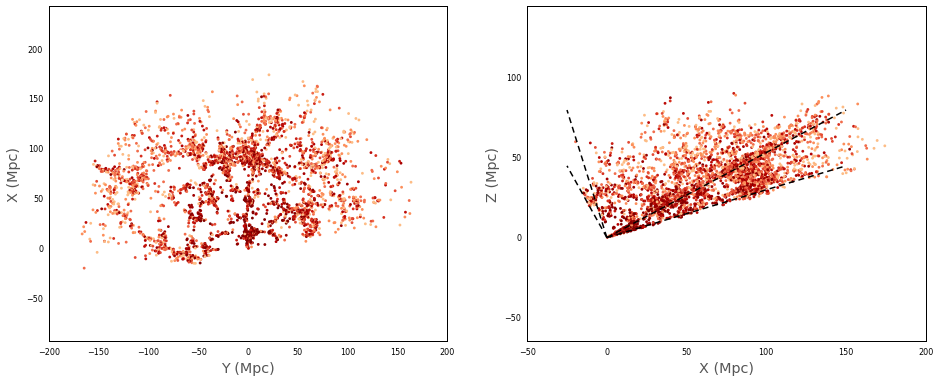

In [120]:
fig,ax = plt.subplots(1,2, figsize=(14,6))

plt.subplot(121)
plt.scatter(mycat['Y'], -1*mycat['X'], s=8, color=plt.cm.OrRd_r(10**(mycat.Zmag-mycat.Zmag.max()) ), edgecolor='None')
plt.xlabel('Y (Mpc)'); plt.ylabel('X (Mpc)')
plt.axis('equal');

#plt.figure(figsize=(7,6))
plt.subplot(122)
plt.scatter(-1*mycat['X'],mycat['Z'], s=8, color=plt.cm.OrRd_r(10**(mycat.Zmag-mycat.Zmag.max()) ), edgecolor='None')
lstyle = dict(lw=1.5, color='k', dashes=(6,4))
plt.plot([0,150], [0,80], **lstyle)
plt.plot([0,150], [0,45], **lstyle)
plt.plot([0,-25], [0,80], **lstyle)
plt.plot([0,-25], [0,45], **lstyle)
plt.xlabel('X (Mpc)'); plt.ylabel('Z (Mpc)')
plt.axis('equal');

In [87]:
mycat.describe()

,Zmag,cz,ra_deg,dec_deg,dist,X,Y,Z
count,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000
mean,14.953974,6812.333538,186.203655,22.481214,100.299020,-64.799021,-9.490795,38.344264
std,0.697509,2781.791768,46.249371,4.362414,41.474895,37.896815,65.403842,17.557857
min,8.900000,31.000000,97.127917,15.000833,0.447238,-174.322147,-166.518595,0.177526
25%,14.800000,4792.500000,149.190208,18.505417,69.998827,-93.320989,-53.625803,26.077586
50%,15.200000,6886.000000,182.644583,22.324444,101.113686,-68.627203,-1.816361,38.189294
75%,15.400000,8881.000000,220.861667,26.526667,131.065547,-34.137557,36.506820,50.170942
max,15.700000,12482.000000,286.765417,29.999722,185.865992,19.650275,163.471919,90.443146


Can we plot something like this??

<img src="http://i.huffpost.com/gen/2023548/thumbs/o-LANIAKEA-MAP-900.jpg?1">

# Map of the Milky Way

http://bessel.vlbi-astrometry.org/parallax


#### Format of input file
|name | l |	b | Prlx | err | $\mu_\alpha$ cos ($\delta$) |err| $\mu_\delta$ | err | v_LSR | err  | Freq | Telescope | Ref | 
|--|--|	-- | -- | -- | -- | -- | -- | --| --| --| -- | -- | 
| [str] | [deg] | [deg] | [mas] | +/- | [mas/yr] | +/- | [mas/yr] | +/- | [km/s] | +/- | [GHz] | [str] | [str] | 
| G105.41+09.87 | 105.41 | 9.87 | 1.129 | 0.063 | -0.21 | 2.38 | -5.49 | 2.38 | -10.0 | 5.0 | 22.2 | VLBA | 2013ApJ...769...15X |

### Read the data

In [88]:
uzcat = pd.read_table('data/bessel.tab',  
                   delim_whitespace=True,
                   names=['name', 'l', 'b', 'prlx', 'prlxerr', 'mua', 'muaerr', 
                          'mud', 'muderr', 'vlsr', 'vlsrerr', 'freq', 'telescope', 'ref'],
                     )

In [89]:
uzcat.head()

,name,l,b,prlx,prlxerr,mua,muaerr,mud,muderr,vlsr,vlsrerr,freq,telescope,ref
0,Sgr-B2M,0.67,-0.04,0.130,0.012,-1.23,0.04,-3.84,0.11,61.0,5.0,22.2,VLBA,2009ApJ...705.1548R
1,Sgr-B2N,0.68,-0.03,0.128,0.015,-0.32,0.05,-4.69,0.11,64.0,5.0,22.2,VLBA,2009ApJ...705.1548R
2,G009.62+00.19,9.62,0.20,0.194,0.023,-0.58,0.05,-2.49,0.27,5.0,3.1,12.2,VLBA,2009ApJ...706..464S
3,G010.47+00.02,10.47,0.02,0.117,0.008,-3.86,0.02,-6.40,0.08,68.9,4.5,22.2,VLBA,2014ApJ...781..108S
4,G010.62-00.38,10.62,-0.38,0.202,0.019,-0.37,0.08,-0.60,0.06,-3.0,2.7,22.2,VLBA,2014ApJ...781..108S


### Convert to Astropy Table

In [90]:
uzcat = Table(data=uzcat.as_matrix(),                    
    names=['name', 'l', 'b', 'prlx', 'prlxerr', 'mua', 'muaerr', 
                          'mud', 'muderr', 'vlsr', 'vlsrerr', 'freq', 'telescope', 'ref'],
    dtype=[str, float, float, float, float, float, float, 
                          float, float,float, float, str, str, str],
     )

In [91]:
uzcat

name,l,b,prlx,prlxerr,mua,muaerr,mud,muderr,vlsr,vlsrerr,freq,telescope,ref
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,str4,str19
Sgr-B2M,0.67,-0.04,0.13,0.012,-1.23,0.04,-3.84,0.11,61.0,5.0,22.2,VLBA,2009ApJ...705.1548R
Sgr-B2N,0.68,-0.03,0.128,0.015,-0.32,0.05,-4.69,0.11,64.0,5.0,22.2,VLBA,2009ApJ...705.1548R
G009.62+00.19,9.62,0.2,0.194,0.023,-0.58,0.05,-2.49,0.27,5.0,3.1,12.2,VLBA,2009ApJ...706..464S
G010.47+00.02,10.47,0.02,0.117,0.008,-3.86,0.02,-6.4,0.08,68.9,4.5,22.2,VLBA,2014ApJ...781..108S
G010.62-00.38,10.62,-0.38,0.202,0.019,-0.37,0.08,-0.6,0.06,-3.0,2.7,22.2,VLBA,2014ApJ...781..108S
G011.49−01.48,11.49,-1.48,0.8,0.033,1.42,0.52,-0.6,0.65,11.0,3.0,12.2,VLBA,2014A&A...566A..17W
G012.02-00.03,12.03,-0.03,0.106,0.008,-4.11,0.02,-7.76,0.27,109.8,2.4,12.2,VLBA,2014ApJ...781..108S
G012.68-0.18,12.68,-0.18,0.416,0.028,-1.0,0.3,-2.85,0.29,56.0,4.0,22,VLBA,2013A&A...553A.117I
G012.81-0.19,12.81,-0.19,0.343,0.037,-0.6,0.11,-0.99,0.13,36.0,4.0,22,VLBA,2013A&A...553A.117I


In [92]:
uzcat['l'].unit = u.deg
uzcat['b'].unit = u.deg
uzcat['prlx'].unit = u.mas
uzcat['prlxerr'].unit = u.mas
uzcat['mua'].unit = u.mas/u.year
uzcat['muaerr'].unit = u.mas/u.year
uzcat['mud'].unit = u.mas/u.year
uzcat['muderr'].unit = u.mas/u.year
uzcat['vlsr'].unit = u.km/u.s
uzcat['vlsrerr'].unit = u.km/u.s
uzcat['freq'].unit = u.GHz

In [93]:
uzcat['mud'].unit

Unit("mas / yr")

In [94]:
uzcat['l'][:5]

0.67
0.68
9.62
10.47
10.62


### Plot the data

In [95]:
distances = 1./uzcat['prlx'].quantity.to(u.arcsec).value * 1e-3

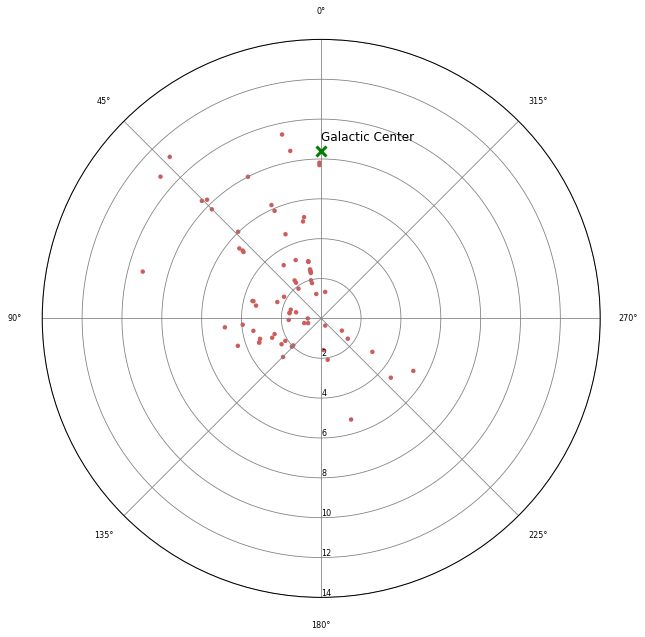

In [96]:
fig = plt.figure( figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
sct = ax.scatter(uzcat['l'].quantity.to(u.rad), distances, 
                     color='IndianRed',
                     #color=plt.cm.RdBu((coords_uzc.dec.deg[selection])/100.), 
                     #s=uzcat['Zmag'][selection_dec*selection_czs], 
                     edgecolors="none",
                    zorder=0)
gc = ax.plot(0,8.4, 'x', ms=10, mew=3, c='Green')
ax.text(0,8.9, 'Galactic Center')
ax.set_rlim(0,10)
ax.set_theta_offset(np.pi/2)
ax.set_rlabel_position(180)
ax.set_rticks(range(2,16,2));
#ax.plot([(ramin*u.deg).to(u.radian).value, (ramin*u.deg).to(u.radian).value], [0,12500], 
#        color='IndianRed', alpha=0.8, dashes=(10,4))
#ax.plot([ramax*np.pi/180., ramax*np.pi/180.], [0,12500],
#        color='IndianRed', alpha=0.8, dashes=(10,4))
#theta = np.arange(ramin, ramax, 1)
#ax.plot(theta*np.pi/180., np.ones_like(theta)*12500,
#        color='IndianRed', alpha=0.8, dashes=(10,4));

# Equatorial and Galactic Coordinates

## Popular packages

    -WCSAxes
    http://wcsaxes.readthedocs.org/

    -PyWCSGrid2
    http://leejjoon.github.io/pywcsgrid2/
    
    - APLpy
    https://aplpy.github.io/
    


### PyWCSGrid2


### APLpy




### WCSAxes
Intended as a replacement for both APLpy, PyWCSGrid2

In [97]:
from astropy.wcs import WCS
from wcsaxes import datasets

#hdu = datasets.fetch_l1448_co_hdu()
hdu = datasets.fetch_msx_hdu()

wcs = WCS(hdu.header)
#hdu.writeto('data/l1558_13co.fits')
try:
    hdu.writeto('data/msx.fits')
except:
    pass

In [98]:
from astropy.io import fits

#hdu = fits.open('data/l1558_13co.fits')[0]

hdu = fits.open('data/msx.fits')[0]
wcs = WCS(hdu.header)

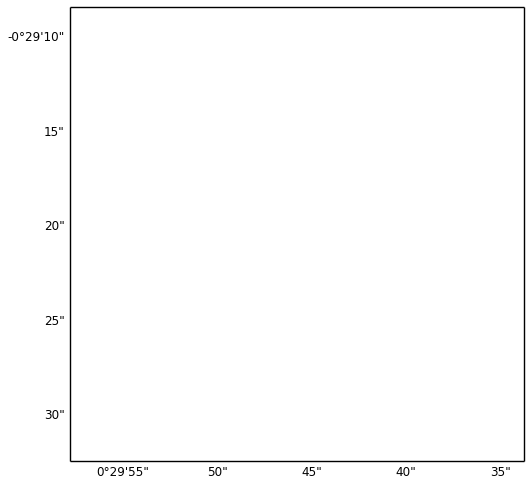

In [99]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9], projection=wcs)

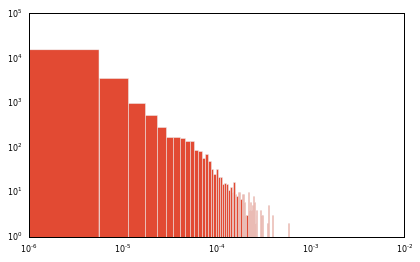

In [100]:
plt.hist(hdu.data.flatten(),bins=500)
plt.yscale('log')
plt.xscale('log')

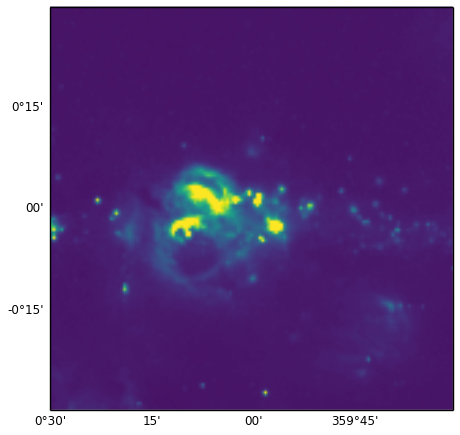

In [101]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs)
ax.imshow(hdu.data, vmin=-1.e-5, vmax=2.e-4, cmap=plt.cm.viridis,
          origin='lower')

# Other